# Predict contributors
This notebook is used to load the test features and predict the labels and confidence using the trained model.
The labels are then saved in a csv file. (Its name is defined in the constant `PRED_FILE`).

Parameters :
- MODEL_NAME : the name of the model to load
- FEATURES_FILE : the name of the csv containing the features of bimbas
- PRED_FILE : the name of the file to save the predictions

In [15]:

#saving the trained model
import joblib
import pandas as pd

In [16]:
RESOURCE_FOLDER = '../resources'
DATA_FOLDER = f'{RESOURCE_FOLDER}/data'
MODEL_FOLDER = f'{RESOURCE_FOLDER}/models'
EVAL_FOLDER = f'{RESOURCE_FOLDER}/evals'

FEATURES_FILE = 'ghmap_features.csv'
MODEL_NAME = 'bimbas.joblib'

PRED_FILE = 't_predictions.csv'

RAND_SEED = 42

# 1 - Load features and labels

,label,DAAR_IQR,DAAR_gini,DAAR_mean,DAAR_median,DAAR_std,DCAR_IQR,DCAR_gini,DCAR_mean,DCAR_median,...,NCAR_median,NCAR_std,NOR,NT,NTR_IQR,NTR_gini,NTR_mean,NTR_median,NTR_std,ORR
contributor,,,,,,,,,,,,,,,,,,,,,
otc-zuul[bot],Bot,1.655,0.916,7.946,0.384,37.296,0.002,0.967,0.409,0.000,...,2.0,1.220,4,5,2.0,0.198,2.922,3.0,1.074,0.078
ljharb,Human,0.336,0.848,0.828,0.084,2.398,0.000,0.860,0.330,0.000,...,1.0,0.967,32,13,1.0,0.263,1.619,1.0,0.917,0.381
juancarlospaco,Human,3.347,0.853,8.808,0.241,22.710,0.000,0.878,1.934,0.000,...,1.0,3.568,18,13,1.0,0.243,1.634,1.0,0.799,0.439
tldr-bot,Bot,NaN,0.000,NaN,NaN,0.000,0.000,0.000,1374.249,1374.249,...,210.0,0.000,1,1,0.0,0.000,1.000,1.0,0.000,1.000
jakirkham,Human,0.309,0.952,3.386,0.073,28.164,0.000,0.864,0.109,0.000,...,1.0,0.770,13,10,1.0,0.265,1.694,1.0,0.959,0.181


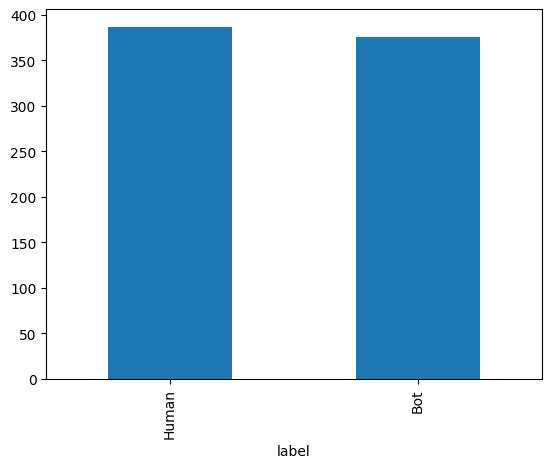

In [17]:
df_test = pd.read_csv(f"{DATA_FOLDER}/{FEATURES_FILE}")
df_test.set_index('contributor', inplace=True)
df_test = df_test[df_test['dataset'] == 'test']
df_test.drop(columns=['dataset'], inplace=True)

df_test['label'].value_counts().plot(kind='bar')
display(df_test.head())

In [18]:
df_label = df_test.copy()
df_label = df_label[['label']]
display(df_label.head())

df_test.drop(columns=['label'], inplace=True)

,label
contributor,
otc-zuul[bot],Bot
ljharb,Human
juancarlospaco,Human
tldr-bot,Bot
jakirkham,Human


# 2 - Load the model

In [19]:
model = joblib.load(f"{MODEL_FOLDER}/{MODEL_NAME}")

# 3 - Predict the labels

In [20]:
from rabbit import compute_confidence
import warnings


def predict(features, model):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        proba = model.predict_proba(features)
    return compute_confidence(proba[0][1])

In [21]:
# Create a df with 4 column but with the "contributor" column as index
df_prediction = pd.DataFrame(columns=['true_bot', 'predicted_bot'])
df_prediction = df_prediction.astype(int)

for contributor in df_test.index:
    true_bot = df_label.loc[contributor, 'label']
    y_prediction, confidence = predict(df_test.loc[[contributor]], model)
    new_row = pd.DataFrame([{
        'contributor': contributor,
        'true_bot': true_bot,
        'predicted_bot': y_prediction,
        'confidence': confidence
    }])
    # Set true_bot and predicted_bot as int
    new_row.set_index('contributor', inplace=True)
    df_prediction = pd.concat([df_prediction, new_row], ignore_index=False)

df_prediction.index.name = 'contributor'
display(df_prediction)

,true_bot,predicted_bot,confidence
contributor,,,
otc-zuul[bot],Bot,Bot,0.708
ljharb,Human,Human,0.694
juancarlospaco,Human,Human,0.798
tldr-bot,Bot,Bot,0.875
jakirkham,Human,Human,0.717
...,...,...,...
mmstick,Human,Human,0.848
asyncapi-bot,Bot,Human,0.493
jeffgbutler,Human,Human,0.751


# 4 - Save the predictions

In [ ]:
df_prediction.to_csv(f"{EVAL_FOLDER}/{PRED_FILE}", index=True)